这个notebook用来可视化和评估CRNN模型的能力

In [1]:
import torch
from torch import nn
from torchvision import models
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
from utils import *

In [8]:
# 这个是从另一个记事本中复制过来的，懒得改了

def get_model_name(epoch, name):
    return f"{name}_{epoch}.pth"

class CRNN(nn.Module):
    """
    这是一个基于CNN和LSTM的CRNN模型，用于生成文本

    """
    def __init__(self, num_classes=128, hidden_dim=1024, io_dim=1024, num_layers=4, bidirectional=True, device='cuda:0', num_beams=20):
        """
        args:
            num_classes: ...
            hidden_dim: int, the dimension of the hidden state of the LSTM
            io_dim: int, the dimension of the input and output of the LSTM
            num_layers: int, the number of layers of the LSTM
            bidirectional: bool, whether to use bidirectional LSTM
            device: str, the device
            num_beams: int, the number of beams used in beam search
        """
        super(CRNN, self).__init__()
        self.direction_factor = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.num_beams = num_beams
        # num-classes对应ascii码表的128种字符
        self.num_classes = num_classes
        # hidden_dim是LSTM的隐藏层（hidden state）和细胞状态（cell state）的维度
        self.hidden_dim = hidden_dim
        # io_dim是LSTM的输入和输出的维度
        self.io_dim = io_dim
        self.device = device
        # max num of characters of the generated text
        self.max_len = 64
        # 1x1卷积层，用于将灰度图转换为3通道图像以适应ResNet的输入
        self.conv1 = nn.Conv2d(1, 3, 1)
        # 使用ResNet50作为CNN的基础模型，去掉最后一层全连接层
        self.cnn = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # output dim is 2048
        # LSTM层，输入维度为io_dim，隐藏层维度为hidden_dim
        self.rnn = nn.LSTM(io_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        # 将CNN的输出转换为LSTM的隐藏状态和细胞状态
        self.h0_fc = nn.Linear(2048, hidden_dim * num_layers * self.direction_factor)
        self.c0_fc = nn.Linear(2048, hidden_dim * num_layers * self.direction_factor)
        # 将LSTM的输出转换为最终的输出，即字符概率分布
        self.out_fc = nn.Linear(hidden_dim * self.direction_factor, num_classes)
        # 将字符的索引转换为字符的embedding
        self.embedding = nn.Embedding(num_classes, io_dim)
        # dropout防止过拟合
        self.dropout = nn.Dropout(0.75)
        self.to(device)
    
    def init_state(self, img):
        # 通过CNN卷出 lstm 的 hidden state 和 cell state
        x = self.conv1(img)         # batch_size, 3, 64, 64
        x = self.cnn(x)             # batch_size, 512, 1, 1
        x = x.view(x.size(0), -1)   # batch_size, 512
        x = x.unsqueeze(0)          # 1, batch_size, 512
        h0 = self.h0_fc(x)          # 1, batch_size, hidden_dim
        c0 = self.c0_fc(x)          # 1, batch_size, hidden_dim
        h0 = h0.view(-1, self.hidden_dim, self.num_layers * self.direction_factor).permute(2, 0, 1).contiguous()  # num_layers * direction_factor, batch_size, hidden_dim
        c0 = c0.view(-1, self.hidden_dim, self.num_layers * self.direction_factor).permute(2, 0, 1).contiguous()  # num_layers * direction_factor, batch_size, hidden_dim
        return h0, c0
    
    def next_char(self, x, h_c_n):
        # print("next char x shape: ", x.shape)
        h_n, c_n = h_c_n
        # x: the embedding of the last character
        # h_n: the hidden state of the last character
        # c_n: the cell state of the last character
        x, (h_n, c_n) = self.rnn(x, (h_n, c_n))
        # print("next char rnn output x shape: ", x.shape)
        x = self.out_fc(x)
        # x = self.dropout(x)
        # print("next char output x shape: ", x.shape)
        return x, (h_n, c_n)
    
    def forward(self, img):
        batch_size = img.size(0)
        h0, c0 = self.init_state(img)
        x = 2  # the index of the start token
        x = torch.tensor([x] * batch_size, dtype=torch.long).view(batch_size, 1).to(self.device)
        x = self.embedding(x)
        # print("after embedding x shape: ", x.shape)
        h_c_n = (h0, c0)
        output = torch.zeros(batch_size, self.max_len, self.num_classes).to(self.device)
        output[:, 0, 2] = 1
        for i in range(1, self.max_len):
            x, h_c_n = self.next_char(x, h_c_n)
            output[:, i, :] = x
            x = x.argmax(dim=-1)
            x = self.embedding(x)
        return output
    
    def forward_beam(self, img):
        # 使用束搜索，生成最可能的文本
        num_beams = self.num_beams
        batch_size = img.size(0)
        h0, c0 = self.init_state(img)
        x = 2  # the index of the start token
        x = torch.tensor([x] * batch_size, dtype=torch.long).view(batch_size, 1).to(self.device)
        x = self.embedding(x)
        h_c_n = (h0, c0)
        output = torch.zeros(batch_size, num_beams, self.max_len, self.num_classes, dtype=torch.long).to(self.device)
        output[:, :, 0, 2] = 1
        probabilities = torch.ones(batch_size, num_beams).to(self.device)
        # 最一开始的时候只有一个beam，所以要先预测一次，得到初始的概率分布，并将其分散到num_beams个beam上
        x, h_c_n = self.next_char(x, h_c_n)
        x = torch.softmax(x, dim=-1).view(batch_size, -1)
        for i in range(batch_size):
            for j in range(num_beams):
                index = x[i].argmax().item()
                output[i, j, 1, index] = 1
                probabilities[i, j] = x[i, index]
                x[i, index] = 0
        x = output[:, :, 1, :].argmax(dim=-1)
        x = self.embedding(x)
        # 将隐状态在beam维度上复制num_beams份
        # 当前shape：num_layers * direction_factor, batch_size, hidden_dim
        # 目标shape：num_layers * direction_factor, batch_size * num_beams, hidden_dim
        h_n, c_n = h_c_n
        h_n = h_n.unsqueeze(2)
        h_n = torch.repeat_interleave(h_n, num_beams, 2)  # num_layers * direction_factor, batch_size, num_beams, hidden_dim
        h_n = h_n.view(self.num_layers * self.direction_factor, batch_size * num_beams, self.hidden_dim)
        c_n = c_n.unsqueeze(2)
        c_n = torch.repeat_interleave(c_n, num_beams, 2)
        c_n = c_n.view(self.num_layers * self.direction_factor, batch_size * num_beams, self.hidden_dim)
        h_c_n = (h_n, c_n)
        # 现在，
        # x:                batch_size, num_beams, io_dim
        # probabilities:    batch_size, num_beams
        # output:           batch_size, num_beams, max_len, num_classes
        # 接下来，每次预测一个字符，然后从中选出最可能的num_beams个预测
        # for i in range(2, self.max_len):
        for i in range(2, self.max_len):
            # 先将batch维度和beam维度合并，以便于LSTM的输入
            x = x.view(batch_size * num_beams, 1, -1)
            h_n = h_n.view(self.num_layers * self.direction_factor, batch_size * num_beams, self.hidden_dim)
            c_n = c_n.view(self.num_layers * self.direction_factor, batch_size * num_beams, self.hidden_dim)
            h_c_n = (h_n, c_n)
            x, h_c_n = self.next_char(x, h_c_n)
            x = torch.softmax(x, dim=-1)
            # 筛选出含有3（结束标志）的beams并将概率设为1，因为这个beam已经结束了
            temp = torch.argmax(output, dim=-1)  # batch_size, num_beams, max_len
            temp = torch.eq(temp, 3).any(dim=-1)  # batch_size, num_beams
            mask_ones = torch.zeros(batch_size, num_beams, self.num_classes, dtype=torch.bool).to(self.device)
            mask_ones[temp] = 1
            mask_ones[:, :, 1:] = 0
            x = x.view(batch_size, num_beams, self.num_classes)
            x[temp] = 0
            x[mask_ones] = 1
            # print("index:", i)
            # print("beams:")
            # for j in range(batch_size):
            #     for k in range(num_beams):
            #         for l in range(i):
            #             print(output[j, k, l].argmax(dim=-1).item(), end=' ')
            #         print(x[j, k].argmax(dim=-1).item())
            # print("mask:", mask_ones)
            x = x * probabilities.view(batch_size, num_beams, 1)
            x = x.view(batch_size, num_beams * self.num_classes)
            # 找出最可能的num_beams个预测，并使用花式索引
            chosens = torch.argsort(x, dim=-1, descending=True)[:, :num_beams]
            chosens_indices = (torch.arange(batch_size).repeat_interleave(num_beams), chosens.contiguous().view(-1))
            # 更新probabilities
            probabilities = x[chosens_indices].view(batch_size, num_beams)
            # 更新输入
            x = x.view(batch_size, num_beams, self.num_classes)
            chosens_indices = (chosens_indices[0], chosens_indices[1] // self.num_classes, chosens_indices[1] % self.num_classes)
            x = chosens_indices[2].view(batch_size, num_beams, 1)
            x = self.embedding(x)
            # 更新输出
            output = output[chosens_indices[0], chosens_indices[1]].view(batch_size, num_beams, self.max_len, self.num_classes)
            # print(output[:, :, :i+1, 65:123])
            out_idx_0 = torch.arange(batch_size).repeat_interleave(num_beams)
            out_idx_1 = torch.arange(num_beams).repeat(batch_size)
            out_idx_3 = chosens_indices[2]
            output[out_idx_0, out_idx_1, i, out_idx_3] = 1
            # 更新隐状态
            h_n, c_n = h_c_n
            # print(f"probabilities: {probabilities}", end=' ')
            # print(f"chosen 1 {chosens_indices[1]}, chosen 2 {chosens_indices[2]}")
            # print(output[:, :, :i+1, 65:123])
            
        return output, probabilities
    
    def beam_output_to_words(self, output):
        # 将模型输出的字符概率分布转换为文本
        batch_size = output.size(0)
        output = output.argmax(dim=-1)
        output = output.cpu().numpy()
        word_beams = []
        for i in range(batch_size):
            words = []
            for j in range(self.num_beams):
                word = ''
                for k in range(1, self.max_len):
                    if output[i, j, k] == 3:
                        break
                    word += chr(output[i, j, k])
                words.append(word)
            word_beams.append(words)
        return word_beams
    
    def output_to_words(self, output):
        # 将模型输出的字符概率分布转换为文本
        batch_size = output.size(0)
        output = output.argmax(dim=-1)
        output = output.cpu().numpy()
        words = []
        for i in range(batch_size):
            word = ''
            for j in range(1, self.max_len):
                if output[i, j] == 3:
                    break
                word += chr(output[i, j])
            words.append(word)
        return words

In [9]:
# load model
model = CRNN()
model_name = get_model_name(13, "Aug")
model_path = "../Machine_Learning_Output/CRNN/"
model.load_state_dict(torch.load(model_path + model_name, weights_only=True))
model.to("cuda:0")
model.eval()

def show_img(img):
    img = img.squeeze().cpu().numpy()
    plt.imshow(img, cmap="gray")
    plt.show()

def get_word(output):
    output = output.cpu().detach().numpy()
    word = ""
    for i in range(1, 64):
        o = np.argmax(output[i])
        if o == 3:
            break
        c = chr(o)
        word += c
    return word

# test
dataset = RecDataset("IAM", "val")
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

answer:  such

predict	probability
soch	18.55%
such	10.82%
scaia	8.23%
sach	6.13%
scon	4.0%


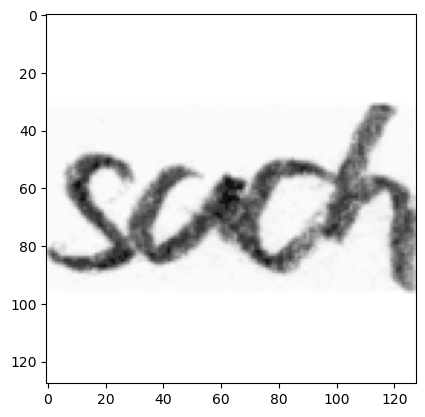

In [94]:
torch.set_printoptions(linewidth=200, precision=4, edgeitems=200, sci_mode=False)
for step, (img, label) in enumerate(dataloader):
    img, label = img.to("cuda:0"), label.to("cuda:0")
    # print(img.min(), img.max(), img.mean())
    output, probability = model.forward_beam(img)
    # 只取第一个样本
    output = output[0]
    probability = probability[0]
    print("answer: ", get_word(label[0]))
    print("\npredict\tprobability")
    for i in range(5):
        print(f"{get_word(output[i])}\t{round(probability[i].item() * 100, 2)}%")
    img = img[0]
    # print(img.min().item(), img.max().item(), img.mean().item())
    
    show_img(img)
    plt.show()
    break

torch.Size([2, 1, 128, 128])
['.', ',', "'", 'a', '"', '..', ':', '-', 'o', 'A', 's', '1', '#', 'I', '2', 'e', '&', '3', '4', '8', '9', '?', ' ', 'O', ';', '6', '7', '5', 'm', ')', 'B', 'W', '0', 'T', "'t", ".'", '(', 'b', '!', 'g', 'R', '.y', '.,', '.-', '/', 'd', 'D', '...', "'f", '+', 'U', 'p', 'L', '*', 'Z', 'S', 'P', '.f', '-.', 'C', 'E', "'s", '\x01', '$', '\x1f', 'N', "'d", '\x0c', '|', '_', "'.", ']', '\x7f', '\x0e', '\x08', 'X', 'Q', 'G', '\x1d', '\x07', '\t', '`', '\x04', '\x12', '\x18', '\r', '\n', '[', '\x1a', ".'d", '\x13', 'y', '\x15', '<', 'Y', '\x10', '\x06', '\x16', '\\', '\x14', '\x11', '~', '{', '\x0f', '\x1b', '\x05', 'V', '=', '\x1c', '\x1e', 'x', 'M', '@', '\x00', '\x0b', '%', '', '\x02', '\x19', '}', '>', '\x17', 'z', '^', '.1', "'g", 'K', 'v', 'J', '.5', 't', 'of', 'Z.', 'H', 'Ze', "'p", 'F', '.9', 'w', ',.', '.0', ".'s", 's.', "'ty", 'it', '.4', '.t', '. ', "..'", 'q', 'C.', '.:', "'l", '."', 'g.', "'-", '..y', '.7', 'V.', 'in', 'at', 'if', '.8', "..'g", '.6', 

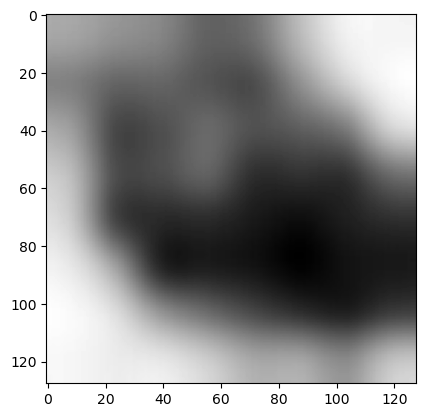

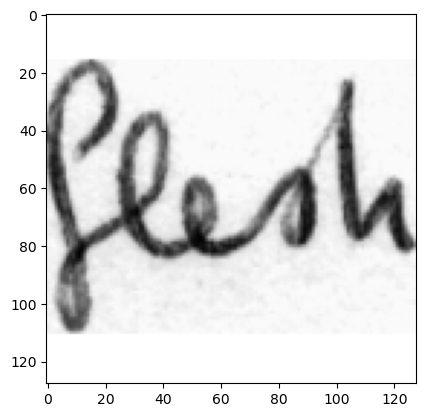

In [5]:
# 使用CRNN自带的to_words函数
for step, (img, label) in enumerate(dataloader):
    img, label = img.to("cuda:0"), label.to("cuda:0")
    print(img.shape)
    output, probability = model.forward_beam(img)
    words_pred = model.beam_output_to_words(output)
    for words in words_pred:
        print(words)
    for img in img:
        show_img(img)
    break

In [6]:
# break the program
raise KeyboardInterrupt

KeyboardInterrupt: 

测试模型在测试数据集上的表现

In [ ]:
def get_test_loss(model, dataloader, device):
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    model.eval()
    loss = 0
    with torch.no_grad():
        for step, (img, target) in enumerate(dataloader):
            img, target = img.to(device), target.to(device)
            h_n, c_n = model.init_state(img)
            h_n, c_n = h_n.to(device), c_n.to(device)
            output = torch.zeros(target.shape[0], model.max_len, model.num_classes).to(device)
            x = target[:, 0]
            output[:, 0] = x
            x = model.embedding(x.long().unsqueeze(1))
            for i in range(model.max_len-1):
                x = model.embedding(target[:, i].argmax(-1).unsqueeze(1))
                x, (h_n, c_n) = model.next_char(x, (h_n, c_n))
                output[:, i+1] = x.squeeze(1)
            loss += criterion(output.view(-1, model.num_classes), target.argmax(-1).view(-1))
    return loss / len(dataloader)

# # test loss
# dataset = RecDataset("IAM", "test")
# dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)
# get_test_loss(model, dataloader, "cuda:0")

测试模型在测试集上的*sequence*精度（完全正确数/总数）

In [ ]:
def get_accuracy(model, dataloader, device, top_n=1):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for step, (img, target) in enumerate(dataloader):
            img, target = img.to(device), target.to(device)
            output, probability = model.forward_beam(img)
            words_pred = model.beam_output_to_words(output)
            words_pred = [words[0] for words in words_pred]
            words_target = model.output_to_words(target)
            for i in range(len(words_pred)):
                if words_pred[i] == words_target[i]:
                    correct += 1
                total += 1
            print(f"\r{correct}/{total}={correct/total: .4f}", end='')
    return correct / total

# test accuracy
from utils import *
from CRNN import *
from torch.utils.data import DataLoader, ConcatDataset
model = CRNN()
model_name = get_model_name(33, "Aug")
model_path = "../Machine_Learning_Output/CRNN/"
model.load_state_dict(torch.load(model_path + model_name, weights_only=True))
model.to("cuda:0")
model.eval()
torch.no_grad()

dataset = RecDataset("IAM", "test"), RecDataset("CVL", "test")
dataset = ConcatDataset(dataset)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
for num_beams in range(1, 10):
    model.num_beams = num_beams
    print(f"num_beams: {num_beams}")
    print(f"\naccuracy: {get_accuracy(model, dataloader, "cuda:0")}")
# num_beams: 500
# 16979/19448= 0.8730
# accuracy: 0.8730460715754833

num_beams: 1
16932/19448= 0.8706
accuracy: 0.8706293706293706
num_beams: 2
16982/19448= 0.8732
accuracy: 0.873200329082682
num_beams: 3
16979/19448= 0.8730
accuracy: 0.8730460715754833
num_beams: 4
16981/19448= 0.8731
accuracy: 0.8731489099136158
num_beams: 5
16979/19448= 0.8730
accuracy: 0.8730460715754833
num_beams: 6
16979/19448= 0.8730
accuracy: 0.8730460715754833
num_beams: 7
16979/19448= 0.8730
accuracy: 0.8730460715754833
num_beams: 8
16979/19448= 0.8730
accuracy: 0.8730460715754833
num_beams: 9
16979/19448= 0.8730
accuracy: 0.8730460715754833


测试模型在测试集上的*character*精度（完全正确数/总数）

In [ ]:
def get_accuracy(model, dataloader, device, top_n=1):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for step, (img, target) in enumerate(dataloader):
            img, target = img.to(device), target.to(device)
            h_n, c_n = model.init_state(img)
            x = model.embedding(torch.tensor([2] * img.size(0)).view(-1, 1).to(device))
            for i in range(model.max_len-1):
                x, (h_n, c_n) = model.next_char(x, (h_n, c_n))
                predict = x.argmax(dim=-1).view(-1)
                answer = target[:, i+1].argmax(dim=-1).view(-1)
                mask = answer != 0
                correct += (predict[mask] == answer[mask]).sum().item()
                total += mask.sum().item()
                x = model.embedding(answer.unsqueeze(1))
            print(f"\r{correct}/{total}={correct/total: .4f}", end='')
    return correct / total

# test accuracy
from utils import *
from CRNN import *
from torch.utils.data import DataLoader
model = CRNN()
model_name = get_model_name(33, "Aug")
model_path = "../Machine_Learning_Output/CRNN/"
model.load_state_dict(torch.load(model_path + model_name, weights_only=True))
model.to("cuda:0")
model.eval()

dataset = RecDataset("IAM", "test"), RecDataset("CVL", "test")
dataset = ConcatDataset(dataset)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
accuracy = get_accuracy(model, dataloader, "cuda:0")
print(f"\naccuracy: {accuracy}")

96587/100978= 0.9565
accuracy: 0.9565152805561608


测试模型在测试集上的平均字符损失

In [ ]:
def get_loss(model, dataloader, device):
    model.eval()
    loss = 0
    count = 0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for step, (img, target) in enumerate(dataloader):
            img, target = img.to(device), target.to(device)
            h_n, c_n = model.init_state(img)
            x = model.embedding(torch.tensor([2] * img.size(0)).view(-1, 1).to(device))
            for i in range(model.max_len-1):
                x, (h_n, c_n) = model.next_char(x, (h_n, c_n))
                predict = x.view(-1, model.num_classes)
                answer = target[:, i+1].argmax(dim=-1).view(-1)
                mask = answer != 0
                loss += criterion(predict[mask], answer[mask]).item()
                count += mask.sum().item()
                x = model.embedding(answer.unsqueeze(1))
            print(f"\r{loss}/{count}={loss/count: .4f}", end='')
    return loss / count

# test accuracy
from utils import *
from CRNN import *
from torch.utils.data import DataLoader, ConcatDataset
model = CRNN()
model_name = get_model_name(33, "Aug")
model_path = "../Machine_Learning_Output/CRNN/"
model.load_state_dict(torch.load(model_path + model_name, weights_only=True))
model.to("cuda:0")
model.eval()

dataset = RecDataset("IAM", "test"), RecDataset("CVL", "test")
dataset = ConcatDataset(dataset)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
loss = get_loss(model, dataloader, "cuda:0")
print(f"\nloss: {loss}")

16154.686915758331/100978= 0.1600
loss: 0.15998224282277657


计算模型的参数量

In [ ]:
from utils import *
from CRNN import *
model = CRNN()
model_name = get_model_name(33, "Aug")
model_path = "../Machine_Learning_Output/CRNN/"
model.load_state_dict(torch.load(model_path + model_name, weights_only=True))

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
cnn_params = sum(p.numel() for p in model.cnn.parameters() if p.requires_grad)
rnn_params = sum(p.numel() for p in model.rnn.parameters() if p.requires_grad)
print(f"total params: {total_params}")
print(f"cnn params: {cnn_params}")
print(f"rnn params: {rnn_params}")

total params: 149812422
cnn params: 23508032
rnn params: 92340224


画混淆矩阵

In [1]:
def get_accuracy(model, dataloader, device, top_n=1):
    model.eval()
    correct = 0
    total = 0
    predict_labels = []
    true_labels = []
    with torch.no_grad():
        for step, (img, target) in enumerate(dataloader):
            img, target = img.to(device), target.to(device)
            h_n, c_n = model.init_state(img)
            x = model.embedding(torch.tensor([2] * img.size(0)).view(-1, 1).to(device))
            for i in range(model.max_len-1):
                x, (h_n, c_n) = model.next_char(x, (h_n, c_n))
                predict = x.argmax(dim=-1).view(-1)
                answer = target[:, i+1].argmax(dim=-1).view(-1)
                mask = answer != 0
                correct += (predict[mask] == answer[mask]).sum().item()
                total += mask.sum().item()
                predict_labels += predict[mask].cpu().numpy().tolist()
                true_labels += answer[mask].cpu().numpy().tolist()
                x = model.embedding(answer.unsqueeze(1))
    return predict_labels, true_labels

# test accuracy
from utils import *
from CRNN import *
from torch.utils.data import DataLoader, ConcatDataset
model = CRNN()
model_name = get_model_name(33, "Aug")
model_path = "../Machine_Learning_Output/CRNN/"
model.load_state_dict(torch.load(model_path + model_name, weights_only=True))
model.to("cuda:0")
model.eval()

dataset = RecDataset("IAM", "test"), RecDataset("CVL", "test")
dataset = ConcatDataset(dataset)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
predicted_labels, true_labels = get_accuracy(model, dataloader, "cuda:0")

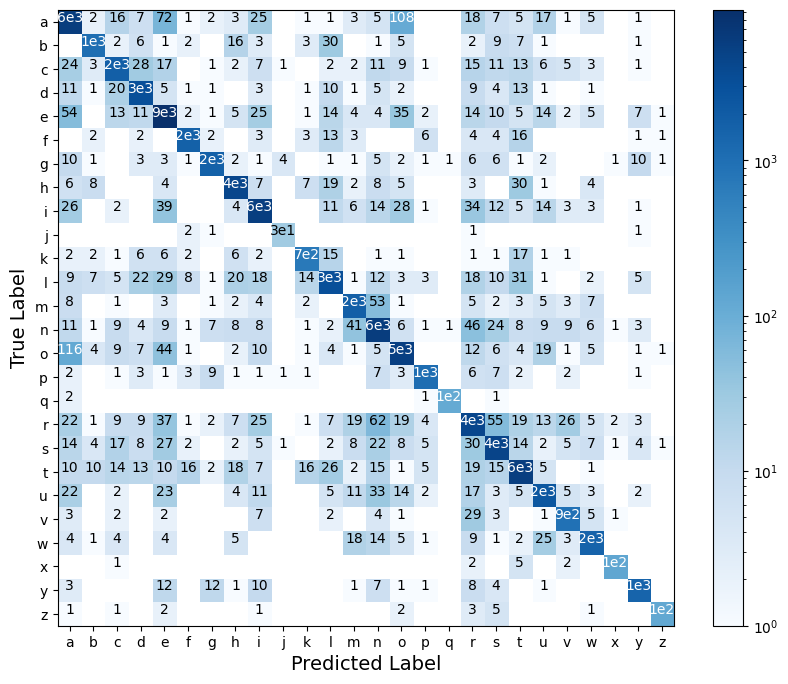

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import confusion_matrix

def filter_labels(predicted_labels, true_labels):
    """
    将所有不是小写字母的字符过滤掉
    """
    char_predicted_labels = []
    char_true_labels = []
    for i in range(len(predicted_labels)):
        if 97 <= predicted_labels[i] <= 122 and 97 <= true_labels[i] <= 122:
            char_predicted_labels.append(predicted_labels[i])
            char_true_labels.append(true_labels[i])
    return char_predicted_labels, char_true_labels

char_predicted_labels, char_true_labels = filter_labels(predicted_labels, true_labels)

# Generate display labels from 'a' to 'z'
display_labels = [chr(i) for i in range(97, 123)]

# Compute confusion matrix
cm = confusion_matrix(char_true_labels, char_predicted_labels, labels=[ord(char) for char in display_labels])

plt.figure(figsize=(10, 8))
# Use imshow to display the confusion matrix with a logarithmic scale
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, norm=mcolors.LogNorm(vmin=1, vmax=cm.max()))
# plt.title('Confusion Matrix (Log Scale)')
plt.colorbar()  # Add a color bar for reference

tick_marks = np.arange(len(display_labels))
plt.xticks(tick_marks, display_labels)
plt.yticks(tick_marks, display_labels)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Optional: Add text annotations inside the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] > 0 and i != j:
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if np.log(cm[i, j]) > np.log(cm.max()) / 2 else "black")
        if i == j:
            text = format(cm[i, j], '.0e').replace('e+0', 'e')
            plt.text(j, i, text, horizontalalignment="center", color="white" if np.log(cm[i, j]) > np.log(cm.max()) / 2 else "black")

plt.show()


['t', 'S', '-', '"', 'U', 'i', 'a', 'l', 'o', ',', 'd', '.', 'I', 'k', 't', 'n', 'S', '.', '"', 'D', 'g', 'a', 'c', 'e', 'o', 'm', ',', 'f', 'a', 'v', 't', 't', 'o', 'e', '\x03', '\x03', 'a', 't', '\x03', 'a', 'n', '\x03', 'a', '\x03', '\x03', 'n', 'h', 'a', 'a', '\x03', '\x03', 'i', 'e', 'n', 'a', 'a', 't', 'a', '\x03', 'r', '\x03', 'i', 'o', 'h', '\x03', 'a', 'k', '\x03', 'r', 'e', 'r', 'o', 'e', 'w', 'l', 'i', 'g', 'd', 'l', 'c', 'h', 'l', 'o', 's', '\x03', 'e', 'v', 'e', 'g', '\x03', 'k', 'w', '\x03', 'a', 'i', 'e', 'g', '\x03', 'l', 'h']
['t', 'S', '-', '"', 'M', 'i', 'a', 'l', 'o', ',', 'd', '.', 'I', 'k', 't', 'n', 'h', '.', "'", 'D', 'g', 'a', 'c', 'e', 'o', 'w', ',', 'f', 'a', 'v', 't', 't', 'o', 'e', '\x03', '\x03', 'a', 't', '\x03', 'a', 'n', '\x03', 'a', '\x03', '\x03', 'n', 'h', 'a', 'a', '\x03', '\x03', 'r', 'i', 'n', 'a', 'a', 't', 'a', '\x03', 'r', '\x03', 'i', 'o', 'h', '\x03', 'a', 'k', '\x03', 'r', 'e', 'r', 'o', 'e', 'v', 'b', 'i', 'n', 'd', 'l', 'c', 'h', 'l', 'o',